In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import poisson

from Generator.parameters import *
%reload_ext autoreload
%autoreload 2

# Distributions

In [51]:
df_language_level = pd.read_csv(file_path["languages_level_path"],index_col=0) # dataframe with language levels

poisson_dist = [poisson(lam=2) for _ in range(60000)]
poisson_x = [i for i in range(max(poisson_dist))]

df_education_level = pd.read_csv(file_path["education_path"]) # dataframe with language levels
education_level_dist =  df_education_level["Distribution"].tolist()
name_edu_levels = df_education_level["Education"]

dt_language = pd.read_csv(file_path["languages_path"],index_col=0)
languages,prob = dt_language.index.to_numpy(), dt_language.Prob.to_numpy()
sorted_order = np.argsort(prob,kind="stable")
languages,prob = languages[sorted_order], prob[sorted_order]

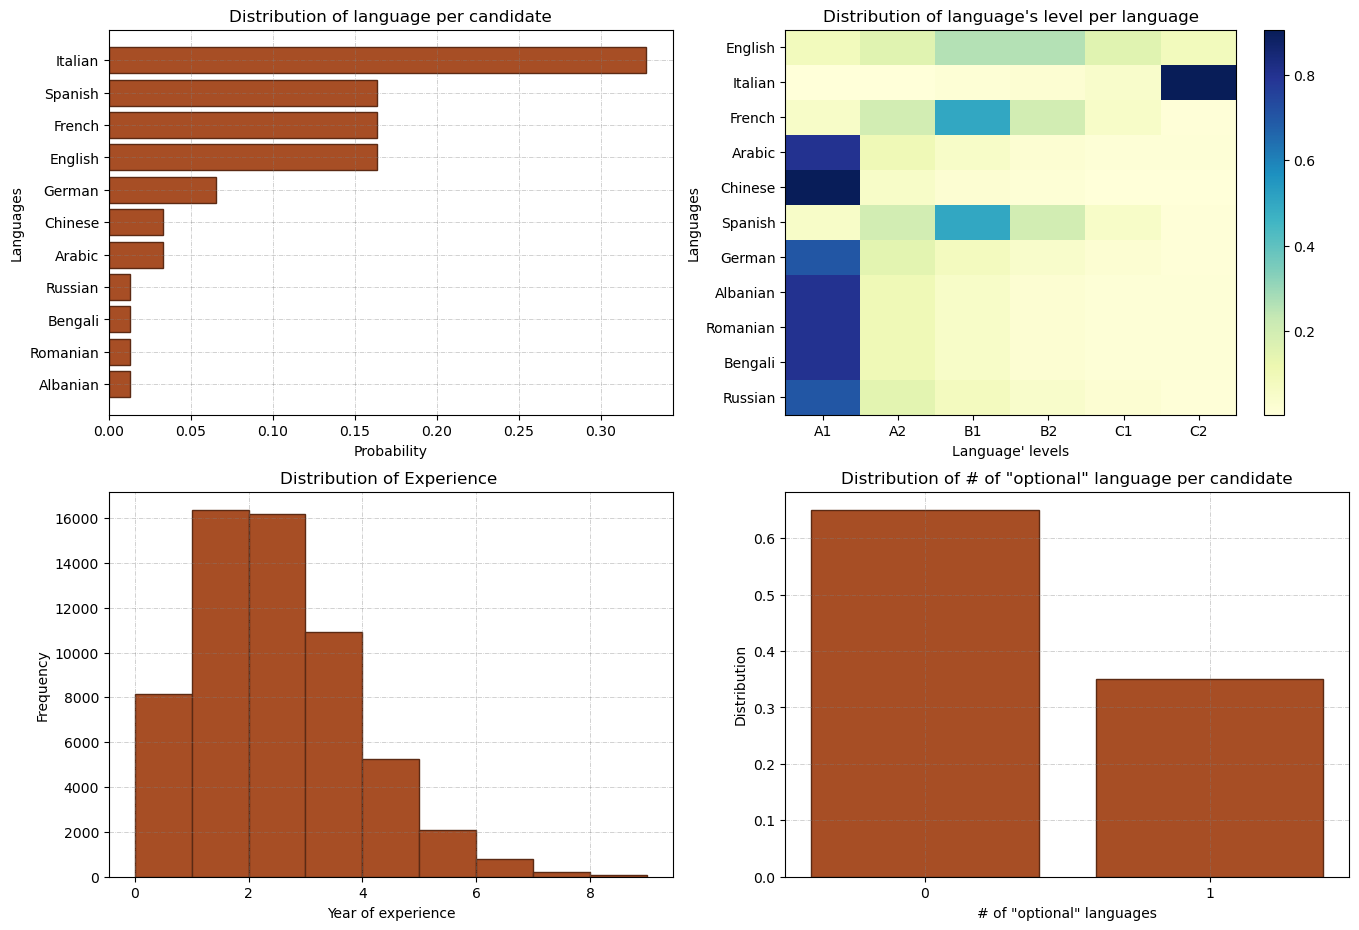

In [52]:
default_par = dict(
    color="#a74e25",
    edgecolor="#5b2a14"
)

f, axs = plt.subplots(ncols=2,nrows=2,figsize=(16,11))

axs[0,0].barh(range(len(languages)), prob/prob.sum(), **default_par)
axs[0,0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[0,0].set_yticks(range(len(languages)), languages)
axs[0,0].set_title('Distribution of language per candidate')
axs[0,0].set_xlabel('Probability')
axs[0,0].set_ylabel('Languages')

img = axs[0,1].imshow(df_language_level.values, cmap='YlGnBu', interpolation='nearest', aspect='auto')
axs[0,1].set_title('Distribution of language\'s level per language')
axs[0,1].set_xticks(range(df_language_level.   shape[1]), list(df_language_level.columns))
axs[0,1].set_yticks(range(df_language_level.shape[0]), list(df_language_level.index))
axs[0,1].set_xlabel('Language\' levels')
axs[0,1].set_ylabel('Languages')

axs[1,0].hist(poisson_dist, poisson_x, **default_par)
axs[1,0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1,0].set_title('Distribution of Experience ')
axs[1,0].set_xlabel('Year of experience')
axs[1,0].set_ylabel('Frequency')

axs[1,1].bar(range(len(file_path["lang_level_distribution"])), file_path["lang_level_distribution"], **default_par)
axs[1,1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1,1].set_xticks(range(len(file_path["lang_level_distribution"])), range(len(file_path["lang_level_distribution"])))
axs[1,1].set_title('Distribution of # of "optional" language per candidate')
axs[1,1].set_xlabel('# of "optional" languages')
axs[1,1].set_ylabel('Distribution')

plt.colorbar(img, ax=axs[0,1])
plt.show()


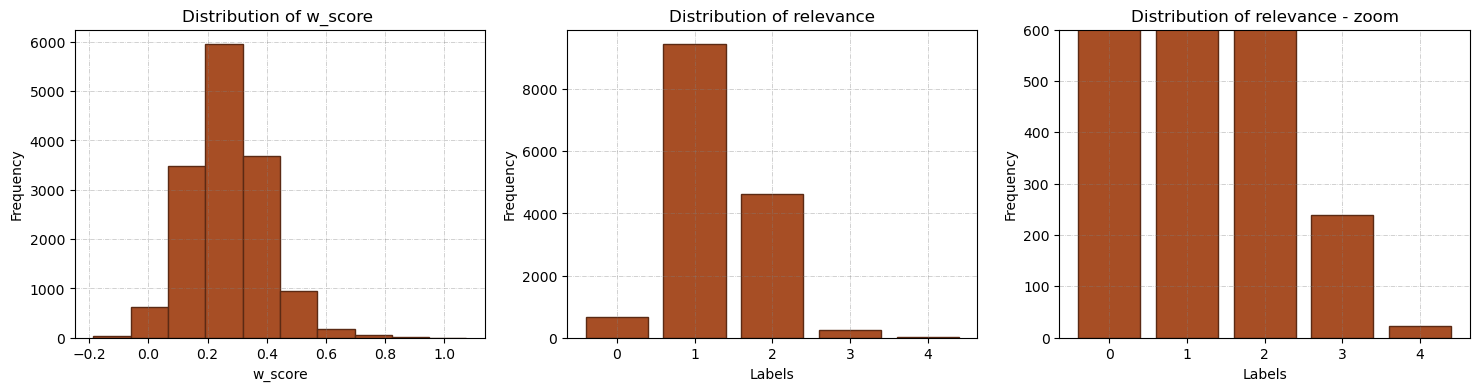

In [5]:
# score_dt = pd.read_csv("../outputs/scores/scores.csv")
# relevance = score_dt["relevance"].tolist()
# w_score = score_dt["w_score"].tolist()
# 
# distri_labels = [relevance.count(i) for i in range(max(relevance)+1)]
# name_label = [*range(max(relevance)+1)]
# 
# _, axs = plt.subplots(ncols=3,figsize=(18,4))
# 
# axs[0].hist(w_score, **default_par)
# axs[0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
# axs[0].set_title('Distribution of w_score ')
# axs[0].set_xlabel('w_score')
# axs[0].set_ylabel('Frequency')
# 
# axs[1].bar(name_label,distri_labels, **default_par)
# axs[1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
# axs[1].set_title('Distribution of relevance')
# axs[1].set_xlabel('Labels')
# axs[1].set_ylabel('Frequency')
# 
# axs[2].bar(name_label,distri_labels, **default_par)
# axs[2].set_ylim(0, 600)
# axs[2].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
# axs[2].set_title('Distribution of relevance - zoom')
# axs[2].set_xlabel('Labels')
# axs[2].set_ylabel('Frequency')
# 
# 
# plt.show()

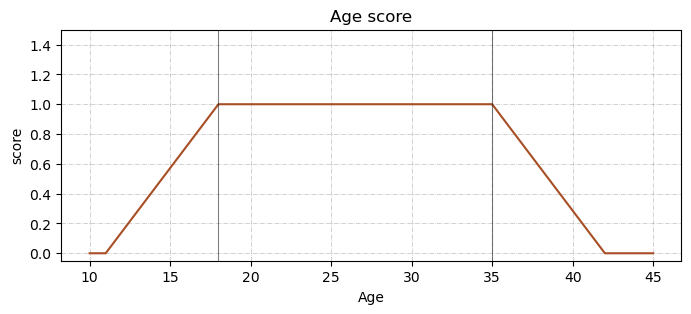

In [6]:
# min_age, max_age = 18, 35
# ages = [*range(10,45+1)]
# age_score = [MatchingScore.ageScore(i,min_age,max_age) for i in ages]
# 
# _, axs = plt.subplots(figsize=(8,3))
# 
# axs.plot(ages,age_score, color=default_par["color"])
# axs.axvline(min_age, alpha=0.5,linewidth=0.8, color="black")
# axs.axvline(max_age, alpha=0.5,linewidth=0.8, color="black")
# axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
# axs.set_title("Age score")
# axs.set_xlabel('Age')
# axs.set_ylabel('score')
# axs.set_ylim(-0.05,1.5)
# plt.show()

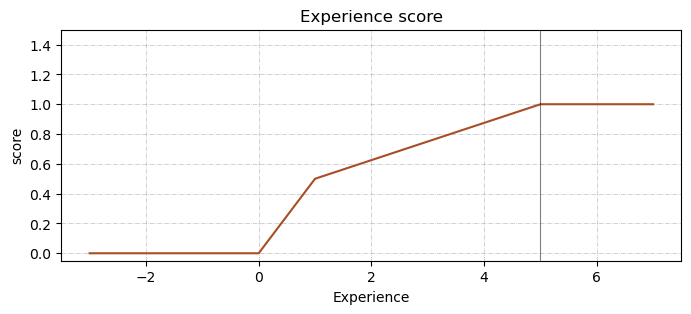

In [7]:
# offer_exp = 5
# experience = [*range(-3,8)]
# exp_score = [MatchingScore.experienceScore(offer_exp, i) for i in experience]
# 
# _, axs = plt.subplots(figsize=(8,3))
# 
# axs.plot(experience, exp_score, color=default_par["color"])
# axs.axvline(offer_exp, alpha=0.5,linewidth=0.8, color="black")
# axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
# axs.set_title("Experience score")
# axs.set_xlabel('Experience')
# axs.set_ylabel('score')
# axs.set_ylim(-0.05,1.5)
# plt.show()

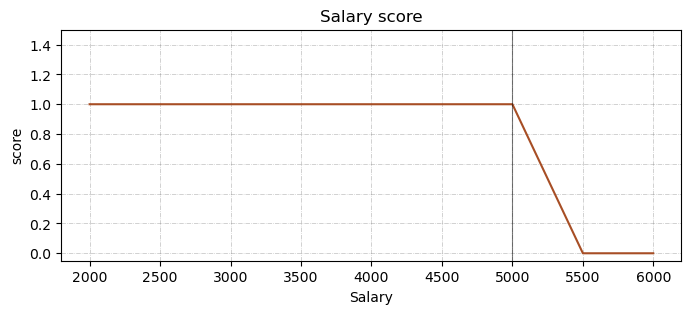

In [8]:
# offer_exp = 5000
# experience = [*range(2000,6000)]
# exp_score = [MatchingScore.salaryScore(offer_exp, i) for i in experience]
# 
# _, axs = plt.subplots(figsize=(8,3))
# 
# axs.plot(experience, exp_score, color=default_par["color"])
# axs.axvline(offer_exp, alpha=0.5,linewidth=0.8, color="black")
# axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
# axs.set_title("Salary score")
# axs.set_xlabel('Salary')
# axs.set_ylabel('score')
# axs.set_ylim(-0.05,1.5)
# plt.show()

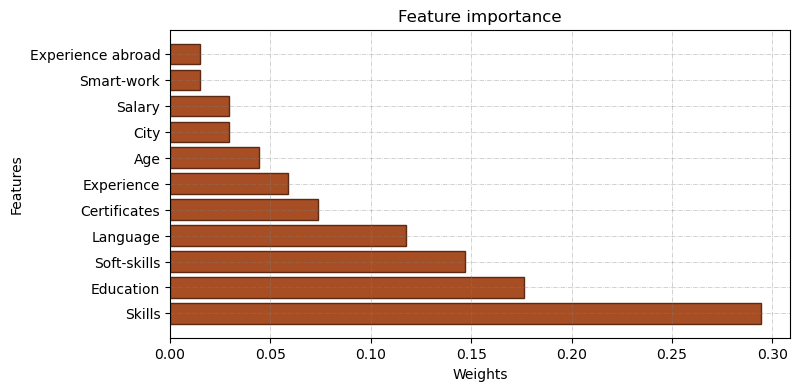

In [9]:
# n_weights = MatchingScore.normalize_weights(matching_par["weight"])
# 
# sort_ = np.argsort(-n_weights)
# 
# features = np.array(["Education","City","Skills","Soft-skills","Age","Language","Certificates","Experience", "Salary","Smart-work","Experience abroad"])
# 
# _, axs = plt.subplots(figsize=(8,4))
# axs.barh(range(len(n_weights)), n_weights[sort_], **default_par)
# axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
# axs.set_yticks(range(len(n_weights)), features[sort_])
# axs.set_title("Feature importance")
# axs.set_xlabel('Weights')
# axs.set_ylabel('Features')
# plt.show()